> Great essay that exceeds the expectations and goes far beyond what was covered in the class. It is more than clear that you know your ways around Python. The code is well documented and well written, showcasing the understanding of advanced methods of data wrangling. The inclusion of automatic detection of optimal number of clusters using `kneed` is a nice bonus as well as the evaluation of the final clusters. One minor note on that - while you have selected optimal number from vanilla k-means, it does not necessarily mean that the same number is optimal for the lagged k-means and regionalization. I understand that it helps comparison to stick to a single value but once you went for the statistical assessment of the ideal solution, it would've been great to include at least a sentence in discussion acknowledging potential issues with that.
>
> Another minor note is on the overall structure - there are long blocks of code cells with minimal Markdown explanation of what are you doing and especially why. It breaks a bit the flow of the essay format. You still had space for those as you now sit at 1100 words, which is a bit on the shorter side.
>
> In any case, great work!
>
> Two additional minor notes below in the code.
>
> Checklist:
> - [x] Contents matches the requirements
> - [x] Word count is within the expected range
> - [x] Code runs as expected
> - [x] Code is well documentated
> - [x] Outputs have proper interpretation
> - [x] Markdown formatting is correct
> - [x] Code is correct
> - [x] Code follows the best practices
> - [x] Code showcases advanced skills
> - [x] Code extends the functionality provided to the student 
> 
> Point deductions:
> 
> - 5 for missing narrative in long code blocks
> - 2 for missing discussion on the optimal number of classes using other clustering methods
> 
> Score: 93
> 
> Grade: 1

# Exploring Spatial Socio-Economic Patterns in Barcelona

### Acknowledgement

This essay uses one additional Python library `kneed` on top of the
infrastructure of the course.

## Introduction

This computational essay is a final assignment for the [Spatial Data Science
for Social Geography (MZ340V17)](https://martinfleischmann.net/sds/) at Charles
University in Prague.

It aims to explore the city of Barcelona's socio-economic patterns, focusing on
key variables such as, [average children per household][1], [yearly gross
taxable income per household (€)][2] and [education level][3] in the scope of
census districts (seccio censal).

The primary goals of this exploratory analysis are as follows:
1. **Exploration of Socio-Economic patterns:**

    Utilize the coding infrastructure of the course to visualize the 
    socio-economic variables. Offering an intro into the city's socio-economic 
    dynamics.

2. **Exploration of spatial autocorrelation:**

    Investigate the degreee of spatial autocorrelation to find patterns of
    spatial similarity or dissimilarity among neighbouring census districts,
    preparing the foundation to the subsequent cluster analysis.

3. **Cluster analysis:**

    Utilize k-means, k-means together with spatial lag and regionalization to
    identify meaningful clusters in Barcelona. The determination of optimal
    cluster number will be based on silhouette score.

4. **Cluster analysis evaluation metrics**

    Evaluate the quality of the used cluster analysis methods using metrics
    such as, isoperimetric quotient, Calinski-Harabasz score and adjusted
    mutual information score, providing insights into effectiveness of each
    clustering approach.

[1]: <https://opendata-ajuntament.barcelona.cat/data/en/dataset/pad_dom_mdbas_edat-0018/resource/6311ebdb-7dda-49a5-b208-03c855999424>
[2]: <https://opendata-ajuntament.barcelona.cat/data/en/dataset/atles-renda-bruta-per-llar>
[3]: <https://opendata-ajuntament.barcelona.cat/data/en/dataset/pad_mdbas_niv-educa-esta_sexe>

## Preparations

### Libraries and data

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import esda
import numpy as np
import pandas as pd

from sklearn.preprocessing import RobustScaler
from sklearn import metrics
from sklearn import cluster
from libpysal import graph
from splot.esda import lisa_cluster, moran_scatterplot
from IPython.display import display

# Additional library for optimal number of clusters
from kneed import KneeLocator

In [2]:
link = 'https://opendata-ajuntament.barcelona.cat/data/dataset/d8e40c96-9f1f-4fd3-86da-2baa1599616d/resource/edaf6642-a51b-4b2b-a492-fa913d5e8b91/download/2021_atles_renda_bruta_llar.csv'
gross_income = gpd.read_file(link)

children = gpd.read_file('./data/2021_pad_dom_mdbas_edat-0018.csv')

edu = gpd.read_file('./data/2021_pad_mdbas_niv-educa-esta_sexe.csv')

seccio = gpd.read_file('./data/seccio_censal')

ERROR 1: PROJ: proj_create_from_database: Open of /home/marek/miniforge3/envs/sds_improved/share/proj failed


### Data Wrangling

In [3]:
# Drop unnecessary columns and rename columns for better understanding
children = children.drop(
    columns=['Data_Referencia',
             'Codi_Barri',
             'Nom_Barri',
             'AEB',
             'geometry',
             'Nom_Districte']
             ).rename(columns={'Codi_Districte': 'district_code',
                               'Seccio_Censal': 'section_code',
                               'Valor': 'households',
                               'DOM_00_18': 'children'}
)
# Convert columns to the correct data type
children['households'] = children['households'].astype(int)
children['children'] = children['children'].astype(int)

# Clean the section code by removing the district code infront
children['district_code_length'] = children['district_code'].str.len()
children['section_code'] = children.apply(
    lambda row: row['section_code'][row['district_code_length']:], axis=1
)
# Drop the temporary column
children = children.drop(columns=['district_code_length'])

# Convert columns to the correct data type
children['section_code'] = children['section_code'].astype(int)
children['district_code'] = children['district_code'].astype(int)

# Calculate average children per household
children['weighted_children'] = children['children'] * children['households']
grouped = children.groupby(['district_code', 'section_code']).agg(
    total_households=('households', 'sum'),
    total_weighted_children=('weighted_children', 'sum')
)
grouped['average_children'] =(
    grouped['total_weighted_children'] / grouped['total_households']
)
# Reset the index and drop temporary columns
children = grouped.reset_index().drop(
    columns=['total_weighted_children',
             'total_households']
)

In [4]:
# Drop unnecessary columns and rename columns for better understanding
gross_income = gross_income.drop(
    columns=['Any', 'Codi_Barri', 'Nom_Barri', 'geometry']
    ).rename(columns={'Import_Renda_Bruta_€': 'gross_income',
                      'Codi_Districte': 'district_code',
                      'Nom_Districte': 'district_name',
                      'Seccio_Censal': 'section_code',}
)
# Convert columns to the correct data type
gross_income['section_code'] = gross_income['section_code'].astype(int)
gross_income['district_code'] = gross_income['district_code'].astype(int)
gross_income['gross_income'] = gross_income['gross_income'].astype(float)

In [5]:
# Drop unnecessary columns and rename columns for better understanding
edu = edu.drop(
    columns=['Data_Referencia',
             'Codi_Barri',
             'Nom_Barri',
             'AEB',
             'geometry',
             'Nom_Districte']
             ).rename(columns={'Codi_Districte': 'district_code',
                               'Seccio_Censal': 'section_code',
                               'Valor': 'people',
                               'NIV_EDUCA_esta': 'education_level',
                               'SEXE': 'gender'}
)

# Clean the section code by removing the district code infront
edu['district_code_length'] = edu['district_code'].str.len()
edu['section_code'] = edu.apply(
    lambda row: row['section_code'][row['district_code_length']:], axis=1
)
# Drop the temporary column
edu = edu.drop(columns=['district_code_length'])

# Convert columns to the correct data type
edu['section_code'] = edu['section_code'].astype(int)
edu['district_code'] = edu['district_code'].astype(int)
edu['people'] = edu['people'].replace('..', 0).astype(float)

# Group by district code, section code, education level and gender and sum the
# people
grouped = edu.groupby([
    'district_code',
    'section_code',
    'education_level',
    'gender']
    )['people'].sum()

# Unstack the grouped data
unstacked = grouped.unstack(level=[2, 3])
unstacked.reset_index(inplace=True)

# Fill the NaN values with 0
unstacked.fillna(0, inplace=True)

# Get rid of the multiindex by joining the columns with an underscore
unstacked.columns = ['_'.join(col) for col in unstacked.columns.values]

# Cleanup after joining the columns and rename the columns for better
# understanding
column_mapping = {
    col: (
        col.replace('_1', '_f')
        .replace('_2', '_m')
        .replace('district_code_', 'district_code')
        .replace('section_code_', 'section_code')
        .replace('1_', 'no_edu_')
        .replace('2_', 'prim_')
        .replace('5_', 'high_')
        .replace('6_', 'no_data_')
        )
        for col in unstacked.columns
}
# Rename the columns
unstacked.rename(columns=column_mapping, inplace=True)

# Merge the third and fourth level of education since Spain has twp different
# levels of high school exams
unstacked['sec_f'] = unstacked['3_f'] + unstacked['4_f']
unstacked['sec_m'] = unstacked['3_m'] + unstacked['4_m']
# Drop the third and fourth level of education
unstacked = unstacked.drop(columns=['3_f', '4_f', '3_m', '4_m'])

# Reorder the columns for more logical order
columns_to_move = ['sec_f', 'sec_m']
new_position = 7

original_columns = unstacked.columns.to_list()

for column in columns_to_move:
    original_columns.remove(column)

for column in columns_to_move:
    original_columns.insert(new_position -1, column)
    new_position += 1

edu = unstacked[original_columns]

In [6]:
# Drop unnecessary columns and rename columns for better understanding
seccio = seccio[['DISTRICTE', 'SEC_CENS', 'geometry']]
seccio = seccio.rename(columns={
    'DISTRICTE': 'district_code',
    'SEC_CENS': 'section_code'}
)
# Convert columns to the correct data type
seccio['district_code'] = seccio['district_code'].astype(int)
seccio['section_code'] = seccio['section_code'].astype(int)

#### Merging

In [7]:
# Merge the dataframes into geopandas dataframe
for df in [children, gross_income, edu]:
    seccio = seccio.merge(df, on=['district_code', 'section_code'])

#### Relative education values

In [8]:
# Get the columns that are related to the education
edu_column = [
    col for col in seccio.columns if col.endswith('_f') or col.endswith('_m')
]
# Calculate the total population by gender aged 16+ 
seccio['pop_f'] = seccio[
    seccio.columns[seccio.columns.str.endswith('_f')]].sum(axis=1)
seccio['pop_m'] = seccio[
    seccio.columns[seccio.columns.str.endswith('_m')]].sum(axis=1)

# Calculate the rate of each education level
for column in edu_column:
    if column.endswith('_f'):
        seccio[column + '_rate'] = seccio[column] / seccio['pop_f'] * 100
    else:
        seccio[column + '_rate'] = seccio[column] / seccio['pop_m'] * 100

seccio.head()

,district_code,section_code,geometry,average_children,district_name,gross_income,no_edu_f,no_edu_m,prim_f,prim_m,...,no_edu_f_rate,no_edu_m_rate,prim_f_rate,prim_m_rate,sec_f_rate,sec_m_rate,high_f_rate,high_m_rate,no_data_f_rate,no_data_m_rate
0,1,5,"POLYGON ((430905.031 4581350.072, 430938.474 4...",1.363542,Ciutat Vella,27950.0,29.0,10.0,237.0,318.0,...,2.917505,0.873362,23.843058,27.772926,40.140845,45.327511,31.388330,23.842795,1.710262,2.183406
1,1,6,"POLYGON ((430874.963 4581396.929, 430870.976 4...",1.318108,Ciutat Vella,33086.0,10.0,6.0,128.0,187.0,...,1.602564,0.722022,20.512821,22.503008,43.108974,46.209386,33.814103,29.362214,0.961538,1.203369
2,1,7,"POLYGON ((430614.207 4581309.336, 430622.668 4...",1.419771,Ciutat Vella,32945.0,10.0,0.0,148.0,311.0,...,1.468429,0.000000,21.732746,29.619048,43.465492,47.428571,32.305433,22.000000,1.027900,0.952381
3,1,8,"POLYGON ((430564.164 4581104.412, 430550.048 4...",1.509542,Ciutat Vella,26200.0,21.0,10.0,360.0,686.0,...,1.860053,0.562746,31.886625,38.604389,44.906997,44.738323,19.574845,14.181204,1.771479,1.913337
4,1,9,"POLYGON ((430275.270 4581082.530, 430331.870 4...",1.433850,Ciutat Vella,30306.0,13.0,6.0,224.0,298.0,...,1.492537,0.579151,25.717566,28.764479,43.857635,44.594595,27.669346,25.096525,1.262916,0.965251


## Exploration

### Visualization

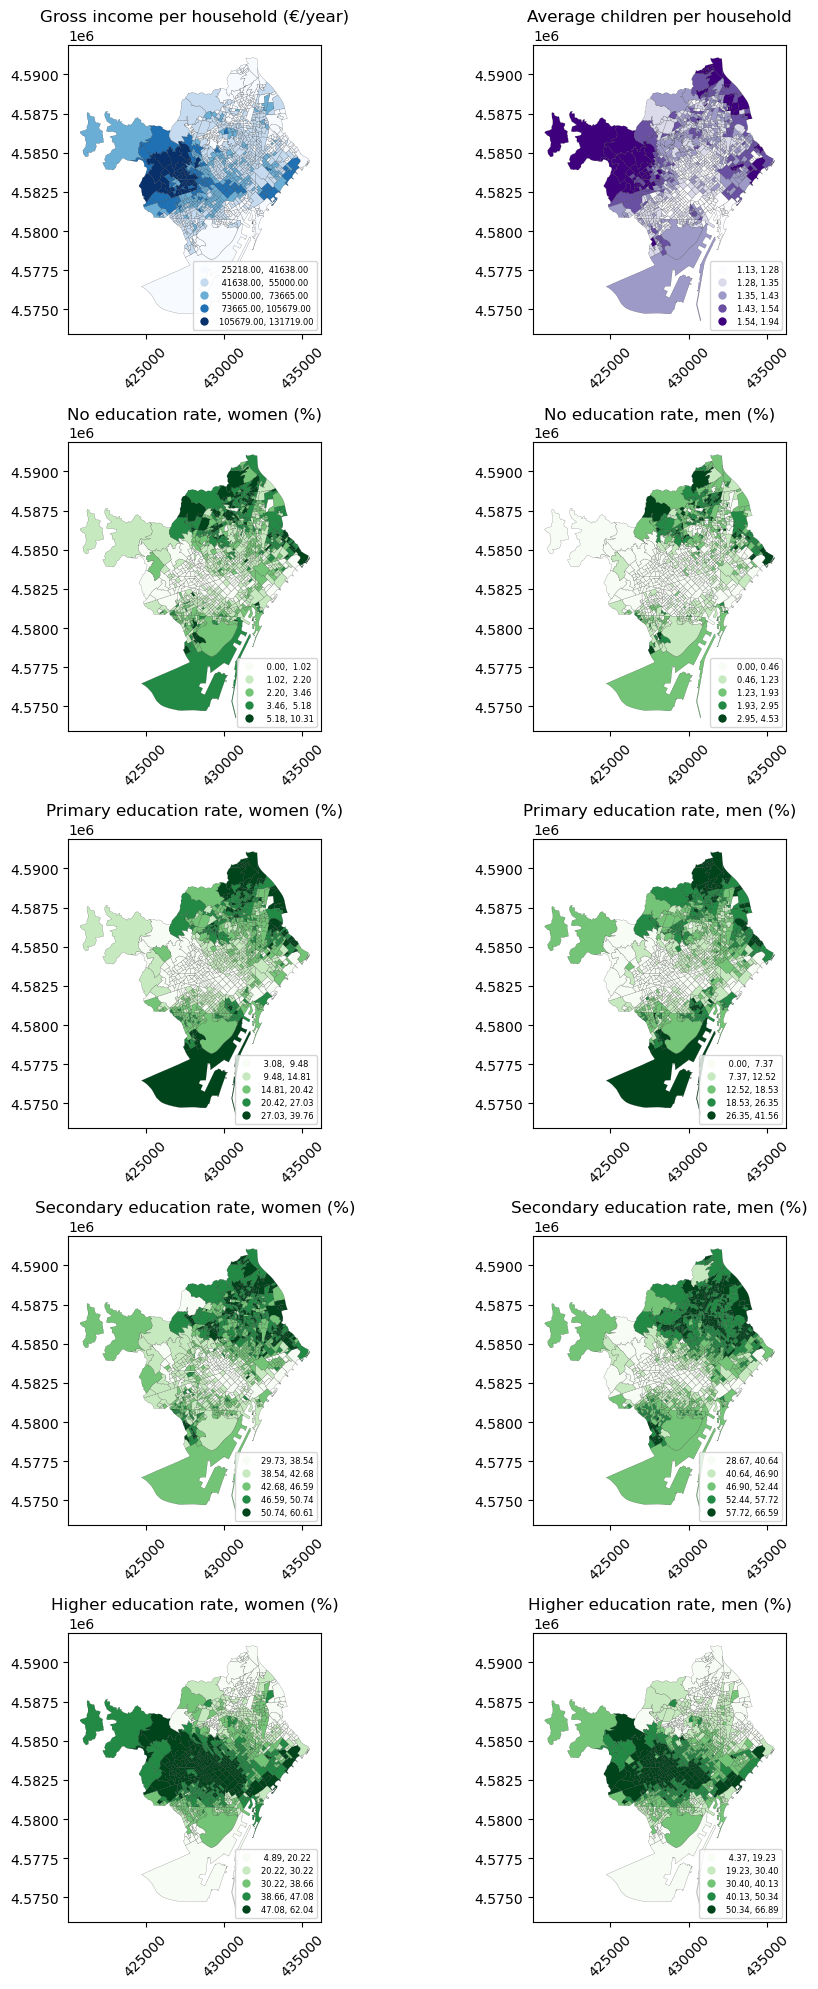

In [9]:
# Plot the data for visual exploration
fig, ax = plt.subplots(5, 2, figsize=(10, 20))

seccio.plot(
    column='gross_income', ax=ax[0, 0],
    legend=True, cmap='Blues',
    scheme='naturalbreaks',
    linewidth=.1, edgecolor='black',
    legend_kwds={
        "fontsize": 6,
        "loc": 'lower right',
        "markerscale": 0.6}
)
seccio.plot(
    column='average_children', ax=ax[0, 1],
    legend=True, cmap='Purples',
    scheme='naturalbreaks',
    linewidth=.1, edgecolor='black',
    legend_kwds={
        "fontsize": 6,
        "loc": 'lower right',
        "markerscale": 0.6}
)
seccio.plot(
    column='no_edu_f_rate', ax=ax[1, 0],
    legend=True, cmap='Greens',
    scheme='naturalbreaks',
    linewidth=.1, edgecolor='black',
    legend_kwds={
        "fontsize": 6,
        "loc": 'lower right',
        "markerscale": 0.6}
)
seccio.plot(
    column='no_edu_m_rate', ax=ax[1, 1],
    legend=True, cmap='Greens',
    scheme='naturalbreaks',
    linewidth=.1, edgecolor='black',
    legend_kwds={
        "fontsize": 6,
        "loc": 'lower right',
        "markerscale": 0.6}
)
seccio.plot(
    column='prim_f_rate', ax=ax[2, 0],
    legend=True, cmap='Greens',
    scheme='naturalbreaks',
    linewidth=.1, edgecolor='black',
    legend_kwds={
        "fontsize": 6,
        "loc": 'lower right',
        "markerscale": 0.6}
)
seccio.plot(
    column='prim_m_rate', ax=ax[2, 1],
    legend=True, cmap='Greens',
    scheme='naturalbreaks',
    linewidth=.1, edgecolor='black',
    legend_kwds={
        "fontsize": 6,
        "loc": 'lower right',
        "markerscale": 0.6}
)
seccio.plot(
    column='sec_f_rate', ax=ax[3, 0],
    legend=True, cmap='Greens',
    scheme='naturalbreaks',
    linewidth=.1, edgecolor='black',
    legend_kwds={
        "fontsize": 6, "loc":
        'lower right',
        "markerscale": 0.6}
)
seccio.plot(
    column='sec_m_rate', ax=ax[3, 1],
    legend=True, cmap='Greens',
    scheme='naturalbreaks',
    linewidth=.1, edgecolor='black',
    legend_kwds={"fontsize": 6,
                 "loc": 'lower right',
                 "markerscale": 0.6}
)
seccio.plot(
    column='high_f_rate', ax=ax[4, 0],
    legend=True, cmap='Greens',
    scheme='naturalbreaks',
    linewidth=.1, edgecolor='black',
    legend_kwds={"fontsize": 6,
                 "loc": 'lower right',
                 "markerscale": 0.6}
)
seccio.plot(
    column='high_m_rate', ax=ax[4, 1],
    legend=True, cmap='Greens',
    scheme='naturalbreaks',
    linewidth=.1, edgecolor='black',
    legend_kwds={"fontsize": 6,
                 "loc": 'lower right',
                 "markerscale": 0.6}
)
# Set the titles
ax[0, 0].set_title('Gross income per household (€/year)')
ax[0, 1].set_title('Average children per household')
ax[1, 0].set_title('No education rate, women (%)')
ax[1, 1].set_title('No education rate, men (%)')
ax[2, 0].set_title('Primary education rate, women (%)')
ax[2, 1].set_title('Primary education rate, men (%)')
ax[3, 0].set_title('Secondary education rate, women (%)')
ax[3, 1].set_title('Secondary education rate, men (%)')
ax[4, 0].set_title('Higher education rate, women (%)')
ax[4, 1].set_title('Higher education rate, men (%)')
# Set the x-axis label rotation for better readability
ax[0, 0].tick_params(axis='x', rotation=45)
ax[0, 1].tick_params(axis='x', rotation=45)
ax[1, 0].tick_params(axis='x', rotation=45)
ax[1, 1].tick_params(axis='x', rotation=45)
ax[2, 0].tick_params(axis='x', rotation=45)
ax[2, 1].tick_params(axis='x', rotation=45)
ax[3, 0].tick_params(axis='x', rotation=45)
ax[3, 1].tick_params(axis='x', rotation=45)
ax[4, 0].tick_params(axis='x', rotation=45)
ax[4, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()

> A lot of code above with minimal Markdown narrative makes it a bit hard to follow.

Visualizing the data on maps, we can clearly see a notable spatial variability
between the census districts.

Looking at yearly gross income per household, there is notable difference
between the census districts. The district Les Corts and Sarria-Sant Gervasi
clearly dominate the whole city in terms of gross income.

Based on average children per household, we can clearly see the difference
in the city's downtown and surrounding areas.

In the scope of primary education, the mostly industrial districts (namely, 
Nou Barris, Sant Andreu and Sants Montjuic - Zona Franca port) shine out.

However, to asses the nature of each parts of Barcelona more thoroughly we must
have a look at spatial autocorrelation and the cluster analysis.

### Global spatial autocorrelation

In [10]:
# Build the queen contiguity weights matrix and row standardize it
contiguity = graph.Graph.build_contiguity(seccio, rook=False)
contiguity_r = contiguity.transform("r")

In [11]:
# Calculate Moran's I and its p-value for each variable and print the results
mi = esda.Moran(seccio['gross_income'], contiguity_r.to_W())

summary = f"""\
Moran's I and p-value
=====================
Gross income:
    statistic: {round(mi.I, 3)}
    p-value: {mi.p_sim}
"""

mi = esda.Moran(seccio['average_children'], contiguity_r.to_W())

summary += f"""\
Children per household:
    statistic: {round(mi.I, 3)}
    p-value: {mi.p_sim}
"""
mi = esda.Moran(seccio['high_f_rate'], contiguity_r.to_W())

summary += f"""\
Higher education, women:
    statistic: {round(mi.I, 3)}
    p-value: {mi.p_sim}
"""

mi = esda.Moran(seccio['high_m_rate'], contiguity_r.to_W())

summary += f"""\
Higher education, men:
    statistic: {round(mi.I, 3)}
    p-value: {mi.p_sim}
"""

mi = esda.Moran(seccio['prim_f_rate'], contiguity_r.to_W())

summary += f"""\
Primary education, women:
    statistic: {round(mi.I, 3)}
    p-value: {mi.p_sim}
"""

mi = esda.Moran(seccio['prim_m_rate'], contiguity_r.to_W())

summary += f"""\
Primary education, men:
    statistic: {round(mi.I, 3)}
    p-value: {mi.p_sim}
"""

print(summary)

Moran's I and p-value
Gross income:
    statistic: 0.833
    p-value: 0.001
Children per household:
    statistic: 0.635
    p-value: 0.001
Higher education, women:
    statistic: 0.866
    p-value: 0.001
Higher education, men:
    statistic: 0.886
    p-value: 0.001
Primary education, women:
    statistic: 0.804
    p-value: 0.001
Primary education, men:
    statistic: 0.8
    p-value: 0.001



The global spatial autocorrelation using Moran's I clearly shows us, that the
chosen variables do seem to be positively correlated over Barcelona. Except the
average children per household variable, the variables show a high positive
rate of spatial autocorrelation. But even the average children per household
shows a notable correlation. 

Given we recieved p-value of 0.001, the lowest possible value we could recieve,
we can deduce with high probability, that the values are not arranged randomly.

### Local spatial autocorrelation

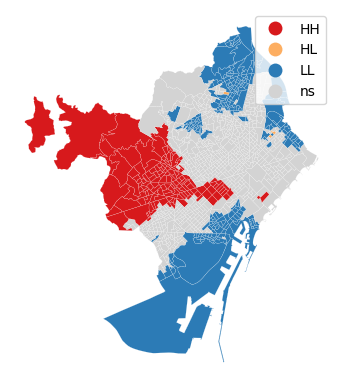

In [12]:
# Plot the LISA cluster map for the gross income
lisa = esda.Moran_Local(seccio['gross_income'], contiguity_r.to_W())
_ = lisa_cluster(lisa, seccio)

The LISA (Local Indicators of Spatial Association) cluster map extracts
statistically significant areas with local association - those that are higly
unlikely to have come from pure randomness. The HH (high-high) cluster groups
together the areas with high values surrounded by high values, the LL (low-low)
cluster, on the other hand groups together areas with low values, surrounded by
low values.

Reading the LISA cluster map of yearly gross taxable income clearly shows
cluster of high gross income in the previously mentioned districts. Similarly
the LL cluster copies the industrial districts or districts close to industrial
areas.

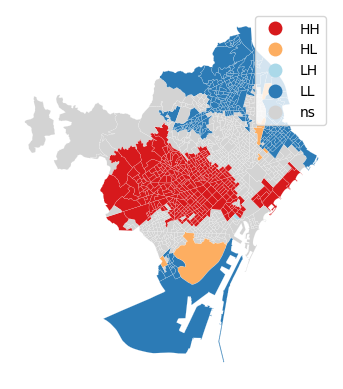

In [13]:
# Plot the LISA cluster map for the higher education of women
lisa = esda.Moran_Local(seccio['high_f_rate'], contiguity_r.to_W())
_ = lisa_cluster(lisa, seccio)

Similar result can be seen while looking at higher education rate. The HH
cluster is located in the downtown area, transitioning into the high gross
income districts. The LL cluster in this example still outlines the highly
industrial areas.

## Clustering

### Preparation

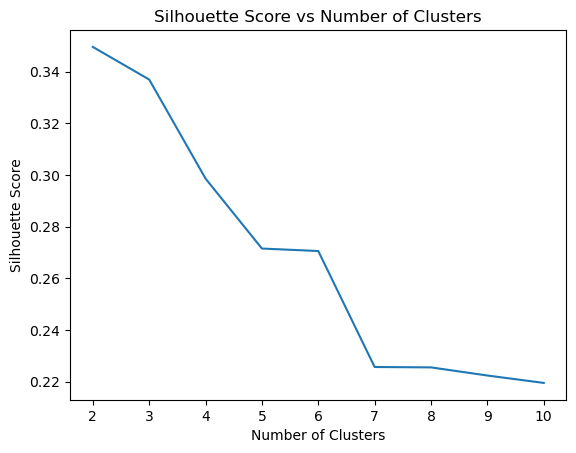

In [14]:
# Prepare the variables for the clustering
subranks = [
    'average_children', 'gross_income',
    'high_f_rate', 'sec_f_rate', 'prim_f_rate', 'no_edu_f_rate',
    'high_m_rate', 'sec_m_rate', 'prim_m_rate', 'no_edu_m_rate'
    ]
# Scale the data using RobustScaler to handle outliers
scaler = RobustScaler()
data_scaled = scaler.fit_transform(seccio[subranks])

# Calculate the silhouette score for different number of clusters
scores = []
for k in range(2, 11):
    kmeans = cluster.KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    scores.append(metrics.silhouette_score(data_scaled, kmeans.labels_))

# Plot the silhouette score for different number of clusters
plt.plot(range(2, 11), scores)
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [15]:
K = [i for i in range(2, 11)]

# Find the optimal number of clusters using the elbow method
# 'K' is the number of clusters and 'scores' is the silhouette score
knee_locator = KneeLocator(K, scores, curve='convex', direction='decreasing')

optimal_clusters = knee_locator.knee

# Print the optimal number of clusters
print(f'The optimal number of clusters is {optimal_clusters}')

The optimal number of clusters is 7


#### KMeans

In [16]:
# Perform k-means clustering with the optimal number of clusters
kmeans = cluster.KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans.fit(data_scaled)
# Add the cluster labels to the dataframe
seccio['kmeans'] = kmeans.labels_

#### Spatially-lagged cluster

In [17]:
# Create new columns for the spatially lagged values of the variables and define
# the variables for the spatially lagged clustering
for column in subranks:
    seccio[column + "_lag"] = contiguity_r.lag(seccio[column])

subranks_lag = [column + "_lag" for column in subranks]
subranks_spatial = subranks + subranks_lag
# Scale the data using RobustScaler to handle outliers
data_scaled_spatial = scaler.fit_transform(seccio[subranks_spatial])

kmeans_lag = cluster.KMeans(n_clusters=optimal_clusters, random_state=42)
kmeans_lag.fit(data_scaled_spatial)
# Add the cluster labels to the dataframe
seccio['kmeans_lag'] = kmeans_lag.labels_

#### Regionalisation

In [18]:
# Perform Agglomerative Clustering with the optimal number of clusters
agg = cluster.AgglomerativeClustering(
    n_clusters=optimal_clusters, connectivity=contiguity.sparse
)

agg.fit(data_scaled)
# Add the cluster labels to the dataframe
seccio['agg'] = agg.labels_

### Visualization

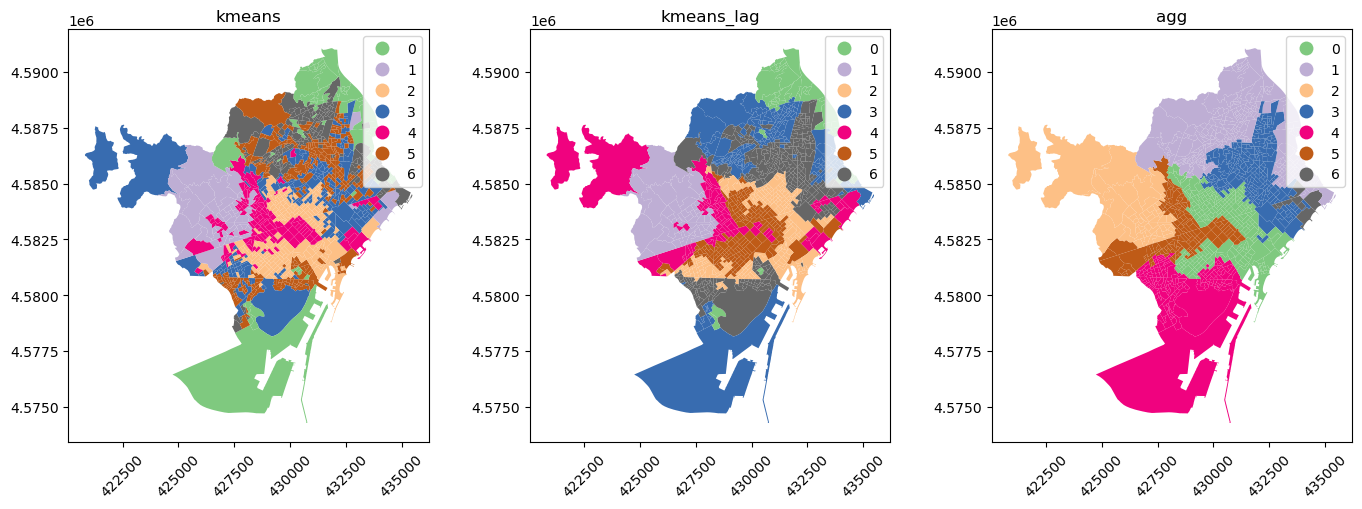

In [19]:
# Plot the different clustering methods on the map
fig, ax = plt.subplots(1, 3, figsize=(14, 5))

seccio.plot(
    column='kmeans',
    ax=ax[0],
    legend=True,
    categorical=True,
    cmap='Accent'
)
seccio.plot(
    column='kmeans_lag',
    ax=ax[1],
    legend=True,
    categorical=True,
    cmap='Accent'
)
seccio.plot(
    column='agg',
    ax=ax[2],
    legend=True,
    categorical=True,
    cmap='Accent'
)
# Set the titles
ax[0].set_title('kmeans')
ax[1].set_title('kmeans_lag')
ax[2].set_title('agg')
# Set the x-axis label rotation for better readability
ax[0].tick_params(axis='x', rotation=45)
ax[1].tick_params(axis='x', rotation=45)
ax[2].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

Each method algorithm groups observations into pre-specified number of
clusters. This analysis uses silhouette score to find the optimal number of
clusters to use. The score is an average standardized distance from each
observation to its "next best fit" cluster. When employing the elbow method,
we seek the point where adding more clusters would no longer result in a
significant decrease in the average standardized distance from each
observation. This 'elbow' point serves as an indication of the optimal number
of clusters, striking a balance between cluster cohesion and the overall
reduction in distance.

The K-means method groups together census districts solely on the statistics,
meaning the spatial distribution has no effect on the defined clusters. However
because of this limitation, this method is very efficient. We can clearly see
it on the visualization, the clusters are not spatially connected.

By adding the information about spatial lag into the K-means algorithm, we can
introduce the needed context of spatial distribution. We can see that clusters
defined by K-means with spatial lag, are much more spatially connected because
of this additional information.

In some cases we might require that all the defined clusters to be spatially
connected. For instance, when the objective is to identify new neighborhoods or
districts, ensuring that clusters are not spatially fragmented is crucial,
unlike the outcome observed in the K-means algorithm results. For this reason
we can turn to regionalization. As evidenced by the resulting clusters above,
the reginalization output showcases clusters interconnected in a visually
cohesive and presentable way.

### Comparison

#### Statistics

In [20]:
k_means = seccio.groupby('kmeans')[subranks].median()
kmeans_stat = k_means.T

k_means_lag = seccio.groupby('kmeans_lag')[subranks].median()
kmeans_lag_stat = k_means_lag.T

agg_clustering = seccio.groupby('agg')[subranks].median()
agg_stat = agg_clustering.T

display(kmeans_stat)
display(kmeans_lag_stat)
display(agg_stat)

kmeans,0,1,2,3,4,5,6
average_children,1.497529,1.592155,1.275821,1.348606,1.385787,1.326637,1.349734
gross_income,31356.000000,131719.000000,53619.000000,52671.000000,75594.000000,44993.000000,37161.000000
high_f_rate,12.914286,51.107473,45.020601,37.049180,51.612903,29.258260,18.097015
sec_f_rate,51.165981,40.494234,40.269170,44.677661,39.484979,47.661897,50.533808
prim_f_rate,30.395137,5.709845,11.793111,14.840989,7.012195,19.054196,24.688279
no_edu_f_rate,3.762136,0.000000,1.604048,2.072539,0.733496,2.667279,4.941176
high_m_rate,9.466264,56.817074,43.708791,34.126984,53.682720,25.211880,14.216478
sec_m_rate,56.081081,36.666052,45.497939,52.325581,39.778449,55.750472,58.504673
prim_m_rate,30.715005,3.112222,8.657890,11.353712,4.539386,16.316583,22.520420
no_edu_m_rate,1.624549,0.000000,0.000000,0.000000,0.000000,1.063645,2.435530


kmeans_lag,0,1,2,3,4,5,6
average_children,1.511468,1.569359,1.299413,1.350000,1.401924,1.299054,1.344538
gross_income,31015.000000,130474.000000,49908.000000,38271.000000,77330.000000,59231.000000,46802.000000
high_f_rate,10.893855,51.057157,39.097802,18.558559,51.295030,48.180678,30.619266
sec_f_rate,51.366743,40.494234,43.341613,50.574713,40.206471,39.341421,46.977547
prim_f_rate,31.019830,5.822862,14.391169,24.400000,6.700337,10.446009,18.104907
no_edu_f_rate,3.942181,0.000000,1.947364,4.404568,0.708942,1.343101,2.526003
high_m_rate,8.219178,56.779123,37.281994,14.450867,54.016903,46.843854,26.782609
sec_m_rate,55.900621,37.150902,49.795833,59.187621,40.257440,44.114002,55.371901
prim_m_rate,31.721195,3.112222,11.026666,22.093023,4.368130,7.324365,14.747475
no_edu_m_rate,1.624549,0.000000,0.000000,2.210884,0.000000,0.000000,0.984529


agg,0,1,2,3,4,5,6
average_children,1.283096,1.375361,1.577405,1.346995,1.320616,1.353075,1.641819
gross_income,53406.000000,37910.500000,130898.000000,47999.000000,44300.500000,72284.500000,73103.000000
high_f_rate,43.868922,18.275673,51.011840,32.192846,32.777553,50.031763,50.961956
sec_f_rate,41.012216,50.576932,40.494234,47.643979,44.695850,40.077967,37.682039
prim_f_rate,12.181303,24.799784,5.912937,16.736402,18.919437,7.718815,8.075002
no_edu_f_rate,1.602959,4.243114,0.000000,2.435312,2.400857,0.847888,0.781780
high_m_rate,42.509363,14.285714,56.685291,28.380386,29.149767,53.532314,46.479111
sec_m_rate,46.557971,58.393285,37.429756,55.584082,51.144370,40.396678,44.180710
prim_m_rate,8.864697,22.259093,3.468872,13.241107,16.286653,4.873945,6.019503
no_edu_m_rate,0.000000,2.077815,0.000000,0.937500,0.923792,0.000000,0.000000


Examining the cluster statistics generated by each clustering method reveals
noteworthy similarities. Notably, cluster `O` of K-means method, cluster
`3` of K-means with spatial lag and cluster `4` of regionalization, all group
together the south industrial part of the city sharing somewhat similar
observations.

#### Geographical and cluster coherence

In [21]:
results = []
for cluster_type in ("kmeans", "kmeans_lag", "agg"):
    # compute the region polygons using a dissolve
    regions = seccio[[cluster_type, "geometry"]].dissolve(by=cluster_type)
    # compute the actual isoperimetric quotient for these regions
    ipqs = (
        regions.area * 4 * np.pi / (regions.boundary.length ** 2)
    )
    # cast to a dataframe
    result = ipqs.to_frame(cluster_type)
    results.append(result)
# stack the series together along columns
compactness = pd.concat(results, axis=1)

ch_scores = []
for cluster_type in ("kmeans", "kmeans_lag", "agg"):
    # compute the CH score
    ch_score = metrics.calinski_harabasz_score(
        # using scaled variables
        data_scaled,
        # using these labels
        seccio[cluster_type],
    )
    # and append the cluster type with the CH score
    ch_scores.append((cluster_type, ch_score))

# re-arrange the scores into a dataframe for display
chscore = pd.DataFrame(
    ch_scores, columns=["cluster type", "CH score"]
).set_index("cluster type")

ami_scores = []
# for each cluster solution
for i_cluster_type in ("kmeans", "kmeans_lag", "agg"):
    # for every other clustering
    for j_cluster_type in ("kmeans", "kmeans_lag", "agg"):
        # compute the adjusted mutual info between the two
        ami_score = metrics.adjusted_mutual_info_score(
            seccio[i_cluster_type], seccio[j_cluster_type]
        )
        # and save the pair of cluster types with the score
        ami_scores.append((i_cluster_type, j_cluster_type, ami_score))
# arrange the results into a dataframe
results = pd.DataFrame(
    ami_scores, columns=["source", "target", "similarity"]
)
# and spread the dataframe out into a square
ami_score = results.pivot(index="source", columns="target", values="similarity")

display(compactness)
display(chscore)
display(ami_score)

,kmeans,kmeans_lag,agg
0,0.033081,0.108564,0.055013
1,0.075555,0.232582,0.106769
2,0.021103,0.027805,0.167446
3,0.013306,0.033720,0.101856
4,0.023645,0.034611,0.108407
5,0.009960,0.049002,0.109718
6,0.019825,0.037184,0.113265


,CH score
cluster type,
kmeans,559.844660
kmeans_lag,458.645083
agg,328.245361


target,agg,kmeans,kmeans_lag
source,,,
agg,1.000000,0.484849,0.542482
kmeans,0.484849,1.000000,0.593148
kmeans_lag,0.542482,0.593148,1.000000


> The tables above are a bit tricky to interpret as it requires me looking at the code, trying to understand what the first one captures. I'd probably split their display over multiple cells with some additional narrative around that.

Looking at isoperimetric quotient or "compactness" we can see that the overall
shape measures for the clusters are notably superior under the regionalization,
underscoring the advantage of this particular method in terms of cluster
cohesion. Intriguingly the cluster `0` and `1` show significantly better
results when employing the K-means method with spatial lag.

Considering the Calinski-Harabasz score, which evaluates the
"within-cluster-variance", the K-means method is clearly the best. This is
based on the nature of the algorithm putting together areas sharing similar
values.

From the solution similarity, we can observe that K-means and K-means method
with spatial lag exhibit the highest degre of self-similarity. Interestingly
the regionalization and K-means with spatial lag demonstrate a relatively
similar level of self-similarity, resembling the K-means methods. This
underscores the effectiveness of incorporating spatial distribution into the
K-means algorithm in this particular case.

## Summary

In this comprehensive exploration of Barcelona's socio-economic patterns, the
computational essay employs the infrastructure of the course. Focusing on
variables like average children per household, yearly gross taxable income per
household, and education level, the study sets out the new rehions based on
these socio-economic observations.

The essay concludes that the choice of clustering method depends on the
specific goals. K-means, efficient and straightforward, excels in minimizing
within-cluster variance. K-means with spatial lag enhances spatial coherence,
particularly in clusters 0 and 1. Regionalization stands out for its ability to
create spatially contiguous and visually cohesive clusters.

## Acknowledgements

This computational essay is a final assignment for the [Spatial Data Science
for Social Geography (MZ340V17)](https://martinfleischmann.net/sds/) at Charles
University in Prague and it is also available at my personal [Github][1].

### References

Rey, Sergio, Dani Arribas-Bel, and Levi John Wolf. 2023. Geographic Data
Science with Python. Chapman & Hall/CRC Texts in Statistical Science. London,
England: Taylor & Francis.

[1]: <https://github.com/novotny-marek/SDS4SG-barcelona-case>